# telechargement de dataset

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohamederrakrai
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:01<00:00, 402MB/s]


# 10 Classes

In [4]:
import os
import shutil

# 2. Define original_train_dir
original_train_dir = '/content/gtsrb-german-traffic-sign/Train'

# 3. Define new_train_dir_10_classes
new_train_dir_10_classes = '/content/gtsrb-german-traffic-sign/Train_10_classes'

# 4. Create the new_train_dir_10_classes directory if it doesn't exist
if os.path.exists(new_train_dir_10_classes):
    shutil.rmtree(new_train_dir_10_classes)
os.makedirs(new_train_dir_10_classes)
print(f"Created directory: {new_train_dir_10_classes}")

# 5. Get a list of all class directories in original_train_dir
all_class_dirs = sorted([d for d in os.listdir(original_train_dir) if os.path.isdir(os.path.join(original_train_dir, d))])

# 6. Select the first 10 class directories from this list
selected_10_classes = all_class_dirs[:10]
print(f"Selected 10 classes: {selected_10_classes}")

# 7. Loop through the selected 10 class directories and copy images
for class_name in selected_10_classes:
    original_class_path = os.path.join(original_train_dir, class_name)
    new_class_path = os.path.join(new_train_dir_10_classes, class_name)

    # a. Create a corresponding subdirectory within new_train_dir_10_classes
    os.makedirs(new_class_path, exist_ok=True)

    # b. Copy all image files from the original class directory to the newly created subdirectory
    for img_file in os.listdir(original_class_path):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            shutil.copy(os.path.join(original_class_path, img_file), new_class_path)

print("Finished copying images for the 10 selected classes.")

Created directory: /content/gtsrb-german-traffic-sign/Train_10_classes
Selected 10 classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17']
Finished copying images for the 10 selected classes.


# augmentation and preprocessing

In [5]:
train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.1,
    fill_mode='nearest'
)

In [6]:
image_size = (224,224)
train_dir = new_train_dir_10_classes

In [7]:
train_data = train_gen.flow_from_directory(
    directory = train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode = 'categorical',
    subset = 'training'


)

Found 11664 images belonging to 10 classes.


In [8]:
val_data = train_gen.flow_from_directory(
    directory = train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode = 'categorical',
    subset = 'validation'


)

Found 1296 images belonging to 10 classes.


# Ttransfer learning




## download the base model

In [6]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    include_top = False,
    input_shape = (224,224,3),
    weights = 'imagenet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## frezz the base model

In [10]:
for layer in base_model.layers:
  layer.trainable = False

## add the fully connected layers

In [17]:
from keras import Sequential
from tensorflow.keras import layers

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Add this layer to flatten the output of ResNet50
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor the validation loss
    patience=3,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
history = model.fit(
    x=train_data,
    batch_size=64,
    validation_data=val_data,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 166s 429ms/step - accuracy: 0.2245 - loss: 2.0607 - val_accuracy: 0.2515 - val_loss: 1.8900
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 147s 403ms/step - accuracy: 0.3645 - loss: 1.7542 - val_accuracy: 0.3588 - val_loss: 1.7545
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 149s 409ms/step - accuracy: 0.4812 - loss: 1.4964 - val_accuracy: 0.4244 - val_loss: 1.6697
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 147s 403ms/step - accuracy: 0.5334 - loss: 1.3595 - val_accuracy: 0.4144 - val_loss: 1.6988
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 146s 401ms/step - accuracy: 0.5625 - loss: 1.2790 - val_accuracy: 0.4498 - val_loss: 1.6777
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 148s 407ms/step - accuracy: 0.5881 - loss: 1.1899 - val_accuracy: 0.4946 - val_loss: 1.5061
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 149s 407ms/step - accuracy: 0.6139 - loss: 1.1317 - val_accuracy: 0.4915 - val_loss: 1.5475
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 149s 408ms/step - accuracy: 0.6131 -

In [ ]:
model.save('traffic_sign_classifier.h5')
print('Model saved successfully as traffic_sign_classifier.h5')

Model saved successfully as traffic_sign_classifier.h5


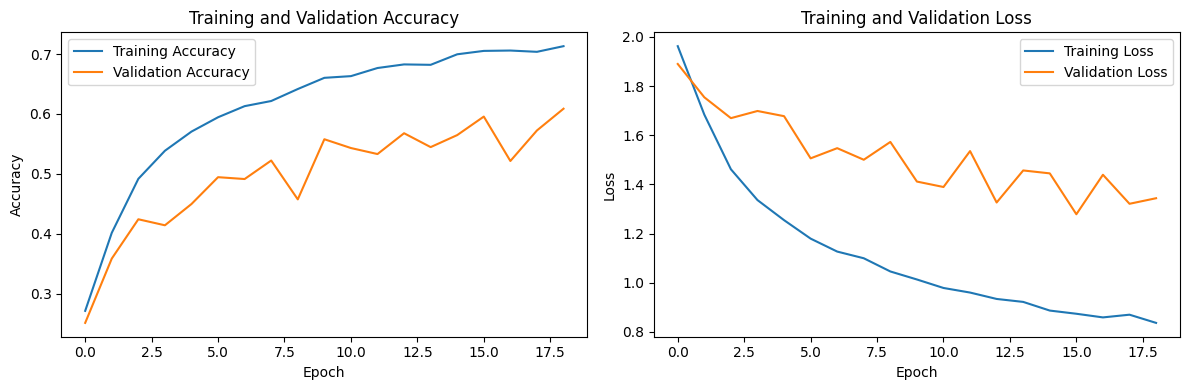

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Fine-tuning

In [37]:
# Your base_model variable is still available from Cell 9
# Let's make the base model trainable
base_model.trainable = True

# Let's freeze all layers up to the last main block (conv5)
# This number (143) is a common choice for ResNet50.
freeze_until_layer = 143

for layer in base_model.layers[:freeze_until_layer]:
    layer.trainable = False

In [44]:
from tensorflow.keras import layers

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])

In [45]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 10-100 times smaller than the default
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
# You can re-use your early stopping callback from Cell 13
# We want to continue from the epochs we already ran

fine_tune_epochs = 30 # Train for 10 *more* epochs

history_fine_tune = model.fit(
    x=train_data,
    validation_data=val_data,
    epochs=fine_tune_epochs,
    callbacks=[early_stopping] # Use the same callback
)

Epoch 1/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 187s 460ms/step - accuracy: 0.5613 - loss: 1.4285 - val_accuracy: 0.6505 - val_loss: 1.1277
Epoch 2/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 159s 435ms/step - accuracy: 0.8259 - loss: 0.5862 - val_accuracy: 0.7099 - val_loss: 0.8856
Epoch 3/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 158s 432ms/step - accuracy: 0.8740 - loss: 0.4301 - val_accuracy: 0.8194 - val_loss: 0.6141
Epoch 4/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 154s 423ms/step - accuracy: 0.9006 - loss: 0.3399 - val_accuracy: 0.7647 - val_loss: 0.8967
Epoch 5/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 154s 423ms/step - accuracy: 0.9076 - loss: 0.3050 - val_accuracy: 0.8187 - val_loss: 0.5879
Epoch 6/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 158s 433ms/step - accuracy: 0.9209 - loss: 0.2625 - val_accuracy: 0.8125 - val_loss: 0.6014
Epoch 7/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 155s 423ms/step - accuracy: 0.9306 - loss: 0.2385 - val_accuracy: 0.7477 - val_loss: 0.9919
Epoch 8/30
365/365 ━━━━━━━━━━━━━━━━━━━━ 155s 425ms/step - accuracy: 0.9302 -

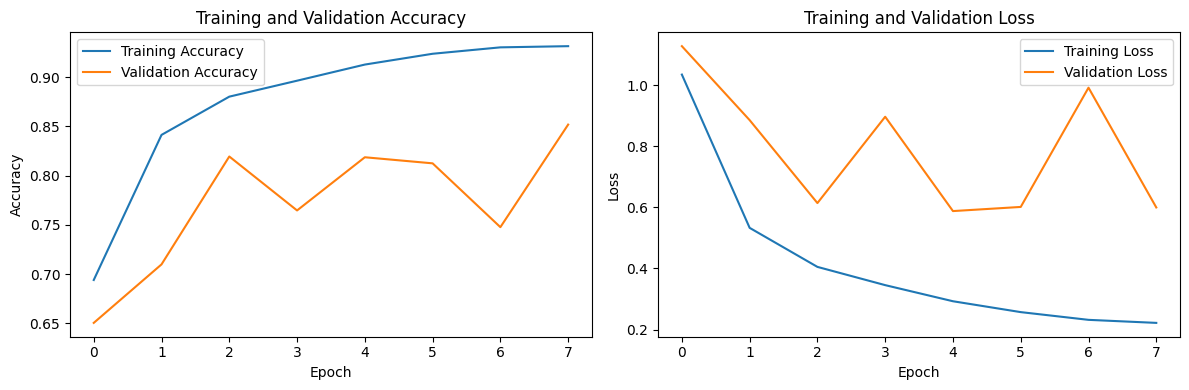

In [47]:
import matplotlib.pyplot as plt

history = history_fine_tune

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [68]:
model.save('traffic_sign_classifier2.h5')
print('Model saved successfully as traffic_sign_classifier.h5')

Model saved successfully as traffic_sign_classifier.h5


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/colab_models/traffic_sign_classifier_fine_tuned.h5')

In [11]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define original_test_dir as the path to the directory containing the test images
original_test_dir = '/content/gtsrb-german-traffic-sign/Test'

# 2. Load the Test.csv file into a pandas DataFrame.
# The Test.csv is typically located in the parent directory of the 'Test' folder.
csv_path = os.path.join(os.path.dirname(original_test_dir), 'Test.csv')


# Correcting the separator from ';' to ',' for Test.csv
test_df = pd.read_csv(csv_path, sep=',')



# 3. Convert the 'ClassId' column in the loaded DataFrame to string type
test_df['ClassId'] = test_df['ClassId'].astype(str)


# selected_10_classes = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17']

# 4. Filter the DataFrame to include only rows where the 'ClassId' is present in the `selected_10_classes` list.
filtered_test_df = test_df[test_df['ClassId'].isin(selected_10_classes)]

# 5. Create a new column in the filtered DataFrame that contains the full path to each image

base_dataset_dir = os.path.dirname(csv_path) # This points to '/content/gtsrb-german-traffic-sign'
filtered_test_df['Path'] = filtered_test_df['Path'].apply(lambda x: os.path.join(base_dataset_dir, x))


print(f"Filtered test DataFrame shape for 10 classes: {filtered_test_df.shape}")


# 6. Instantiate an ImageDataGenerator for the test set (no augmentation, only rescale)
test_datagen = ImageDataGenerator(
    rescale=1/255
)


# 7. Generate the test_data using the flow_from_dataframe method
test_data = test_datagen.flow_from_dataframe(
    dataframe=filtered_test_df,
    x_col='Path',
    y_col='ClassId',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Do not shuffle test data for consistent evaluation
)

# 8. Evaluate the model
print("\nEvaluating the model on the test set...")
loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Filtered test DataFrame shape for 10 classes: (4260, 8)
Found 4260 validated image filenames belonging to 10 classes.


/tmp/ipython-input-3643188293.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df['Path'] = filtered_test_df['Path'].apply(lambda x: os.path.join(base_dataset_dir, x))
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating the model on the test set...
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 105ms/step - accuracy: 0.9444 - loss: 0.1807
Test Loss: 0.1802
Test Accuracy: 0.9462


In [15]:
predictions = model.predict(test_data)
print("Predictions generated successfully.")

134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step
Predictions generated successfully.


In [16]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Get true labels
y_true = test_data.classes

# Get the class indices mapping from the generator
label_map = test_data.class_indices

# Get the ordered list of class names (string labels) as recognized by the generator
# This is important because the confusion matrix will use this order.
class_labels_ordered_str = sorted(label_map, key=label_map.get)

# Convert predictions (one-hot encoded probabilities) to class indices
y_pred_indices = np.argmax(predictions, axis=1)

print("True labels and predicted indices prepared.")


True labels and predicted indices prepared.


In [17]:
from sklearn.metrics import f1_score, recall_score

f1_weighted = f1_score(y_true, y_pred_indices, average='weighted')


recall_weighted = recall_score(y_true, y_pred_indices, average='weighted')

print(f"Overall F1 Score (Weighted Average): {f1_weighted:.4f}")
print(f"Overall Recall Score (Weighted Average): {recall_weighted:.4f}")



Overall F1 Score (Weighted Average): 0.9442
Overall Recall Score (Weighted Average): 0.9462


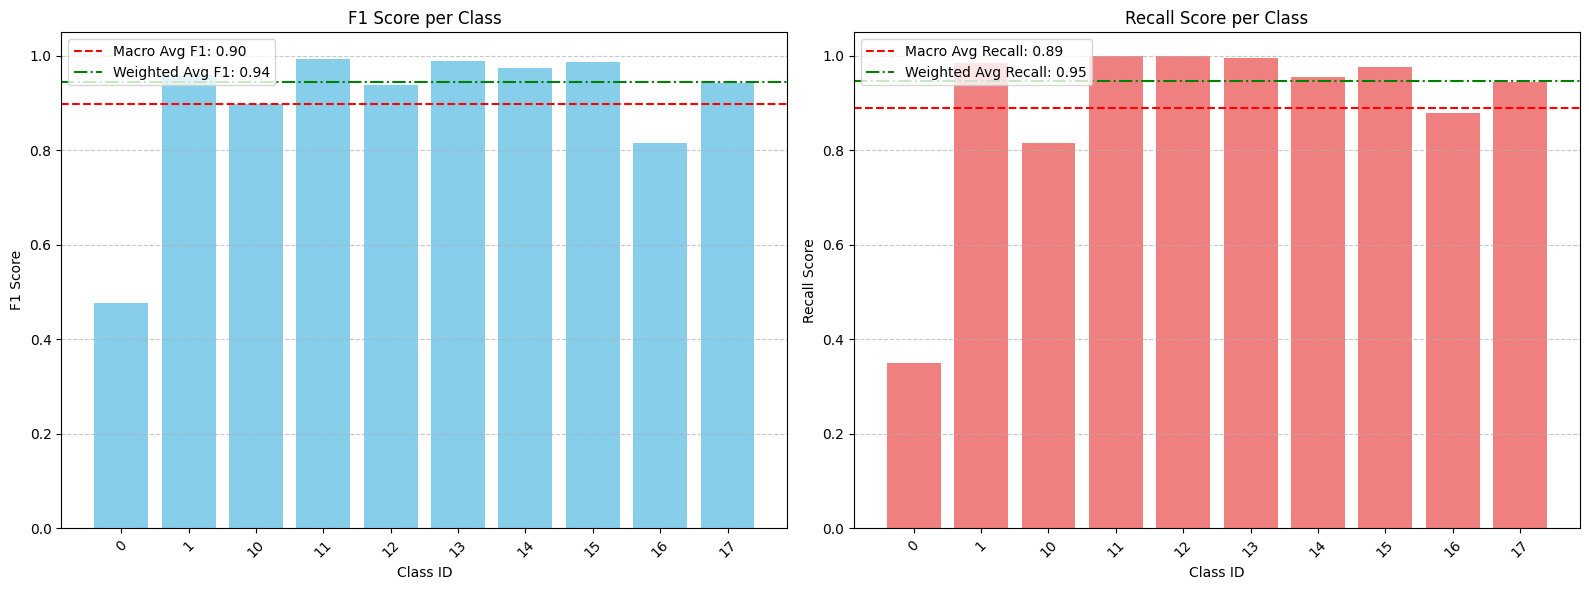

In [26]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Assuming f1_macro, f1_weighted, recall_macro, recall_weighted, f1_per_class,
# recall_per_class, and class_labels_ordered_str are available from previous executions.

metrics_df = pd.DataFrame({
    'Class': class_labels_ordered_str,
    'F1 Score': f1_per_class,
    'Recall Score': recall_per_class
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot F1 Score
axes[0].bar(metrics_df['Class'], metrics_df['F1 Score'], color='skyblue')
axes[0].axhline(y=f1_macro, color='r', linestyle='--', label=f'Macro Avg F1: {f1_macro:.2f}')
axes[0].axhline(y=f1_weighted, color='g', linestyle='-.', label=f'Weighted Avg F1: {f1_weighted:.2f}')
axes[0].set_title('F1 Score per Class')
axes[0].set_xlabel('Class ID')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0, 1.05)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Recall Score
axes[1].bar(metrics_df['Class'], metrics_df['Recall Score'], color='lightcoral')
axes[1].axhline(y=recall_macro, color='r', linestyle='--', label=f'Macro Avg Recall: {recall_macro:.2f}')
axes[1].axhline(y=recall_weighted, color='g', linestyle='-.', label=f'Weighted Avg Recall: {recall_weighted:.2f}')
axes[1].set_title('Recall Score per Class')
axes[1].set_xlabel('Class ID')
axes[1].set_ylabel('Recall Score')
axes[1].set_ylim(0, 1.05)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

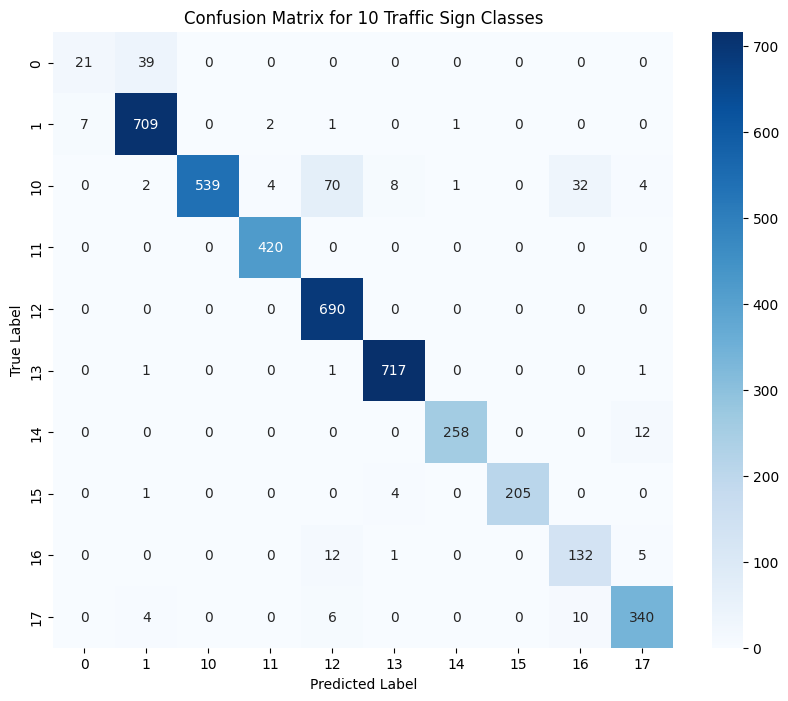

Confusion matrix computed and plotted.


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_indices)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels_ordered_str, yticklabels=class_labels_ordered_str)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for 10 Traffic Sign Classes')
plt.show()

print("Confusion matrix computed and plotted.")